In [67]:
import pandas as pd 
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt

import py2neo

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


# Query Database

In [3]:
def query_database(query):
    # REMEMBER TO BE CONNECTED TO IMPERIAL WIFI!
    graph_db = py2neo.Graph("https://dsi-bitcoin.doc.ic.ac.uk:7473/db/data/", auth=("guest_ro", "imperialO_nly"))
    return graph_db.run(query)

In [4]:
def get_block_data(first_block, last_block):
    query_string = """
                    MATCH (b:Block) <-[:MINED_IN]- (t:Tx) <-[:IN]- (txi:TxIn) <-[:UNLOCK]- (iadr:Address)
                    WHERE b.height >= {} AND b.height <= {}
                    MATCH (txi) <-[:SPENT]- (txo_in:TxOut) 
                    MATCH (oadr:Address) <-[:LOCK]- (txo_out:TxOut) <-[:OUT]- (t)
                    
                    RETURN iadr.address as iadr, oadr.address as oadr, txo_in.value as input_val, txo_out.value as output_val, ID(txo_in) as id_txo_in, ID(txi) as id_txi, ID(t) as id_t, ID(txo_out) as id_txo_out
                    """.format(first_block, last_block)
    return query_string

In [5]:
df = query_database(get_block_data(400000,400000)).to_data_frame()

In [ ]:
#Check if any columns are unique
for column in df:
    print(df[column].is_unique)

In [ ]:
print(df['oadr'].value_counts().sort_values(ascending=False))
df1 = df.loc[df['iadr'] == '1BQLNJtMDKmMZ4PyqVFfRuBNvoGhjigBKF']

# CLUSTERING

In [20]:
cluster = (
    df.groupby('id_t')
    .agg({
        'input_val': 'sum',
        'id_txi': 'nunique',
        'id_txo_out': 'nunique',
        'iadr': 'nunique',
        'oadr': 'nunique',       
    }).rename(columns = {
        'iadr':'num_unique_addr_in',
        'oadr':'num_unique_addr_out'
    })
)

cluster['ratio'] = cluster['id_txi'] / cluster['id_txo_out']
cluster['degree'] = cluster['id_txi'] + cluster['id_txo_out'] 

cluster = cluster.drop(columns=['id_txi', 'id_txo_out'])

In [38]:
cluster.head()

,num_unique_addr_in,input_val,num_unique_addr_out,ratio,degree
id_t,,,,,
113000164,1,0.192061,1,1.0,2
113000165,1,13.410992,2,1.5,5
113000166,1,3.210000,1,1.0,2
113000167,1,0.090000,1,1.0,2
113000168,1,1.546210,1,1.0,2


In [46]:
#Normalize data

scaler = sk.preprocessing.StandardScaler()
scaled_cluster = scaler.fit_transform(cluster)
cluster_scaled = pd.DataFrame(scaled_cluster, columns=cluster.columns, index=cluster.index)

In [47]:
cluster_scaled.head()

,num_unique_addr_in,input_val,num_unique_addr_out,ratio,degree
id_t,,,,,
113000164,-0.350696,-0.182966,-0.466723,-0.177293,-0.494307
113000165,-0.350696,-0.143984,-0.117934,-0.025747,-0.039946
113000166,-0.350696,-0.174067,-0.466723,-0.177293,-0.494307
113000167,-0.350696,-0.183267,-0.466723,-0.177293,-0.494307
113000168,-0.350696,-0.178973,-0.466723,-0.177293,-0.494307


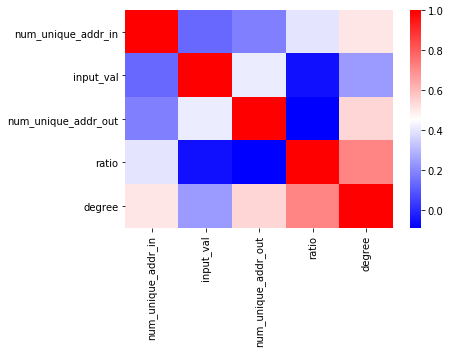

In [48]:
data_corr = cluster.corr()

import seaborn as sb ##includes convenient heatmaps and boxplots
sb.heatmap(data_corr, cmap = 'bwr') #heatmap of correlation matrix

In [63]:
#split data into train and test sets
clus_train, clus_test = sk.model_selection.train_test_split(cluster_scaled, test_size=0.3, random_state=123)

Text(0.5,1,'Selecting k with the Elbow Method')

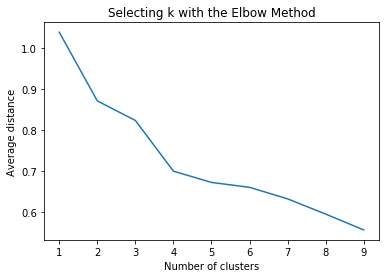

In [69]:
import scipy as sp

clusters = range(1,10)
meandist=[]

for k in clusters:
    model = sk.cluster.KMeans(n_clusters = k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(sp.spatial.distance.cdist(clus_train,model.cluster_centers_,'euclidean'),axis=1))/clus_train.shape[0])
    
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')



# Evaluating K Means clustering performance using elbow method

([<matplotlib.axis.XTick at 0x1a149f7c90>,
 <a list of 18 Text xticklabel objects>)

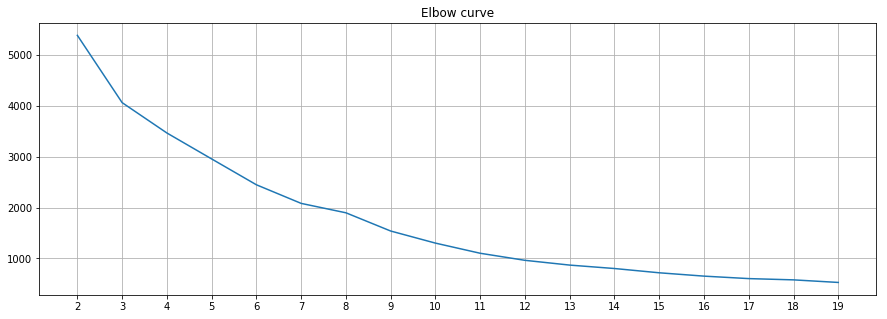

In [56]:
from sklearn.cluster import KMeans


# Convert DataFrame to matrix
mat = cluster_scaled.values
distorsions = []
x = range(2, 20)
for k in x:
    #Perform K Means
    kmeans = sk.cluster.KMeans(n_clusters=k)
    kmeans.fit(mat)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(x, distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show
plt.xticks(x)

# Run K Means and assign centroids to transactions

In [53]:
# Using sklearn
km = sk.cluster.KMeans(n_clusters=5)
km.fit(mat)
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
data = {'transaction_id':cluster_scaled.index,'cluster_label':labels}
results = pd.DataFrame(data)

In [54]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
cluster_label     1600 non-null int32
transaction_id    1600 non-null int64
dtypes: int32(1), int64(1)
memory usage: 18.8 KB


In [55]:
results.head()

,cluster_label,transaction_id
0,2,113000164
1,2,113000165
2,2,113000166
3,2,113000167
4,2,113000168


# Trying to visualize K Means

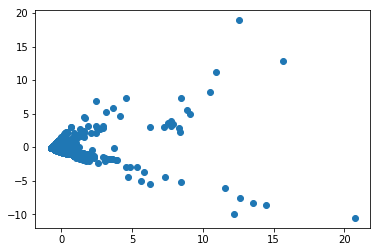

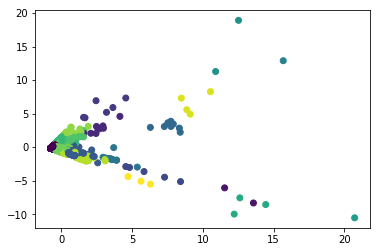

In [58]:
import pylab as pl

pca = sk.decomposition.PCA(n_components=2).fit(mat)
pca_2d = pca.transform(mat)
pl.figure('Reference Plot')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1])

km = sk.cluster.KMeans(n_clusters=4)
km.fit(mat)
pl.figure('K-means with 4 clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
pl.show()



In [ ]:
from sklearn.manifold import TSNE

mat_tsne = TSNE(n_components=2).fit_transform(mat)

# Finding users by using heuristic measures

In [160]:
from collections import defaultdict

users_dict = defaultdict(lambda: {'iadr': set(), 'oadr': set()})
address_dict = defaultdict(lambda: {'user':set()})

In [178]:
iadr = (
    df.groupby('id_t')
    .agg({
        'iadr': 'nunique't    
    })
)

oadr

# users_dict = {user: iadr, oadr for (user, iadr, oadr) in df['id_']}

df.head()

,iadr,id_t,id_txi,id_txo_in,id_txo_out,input_val,oadr,output_val
0,1N8GuEfDx4yUn58uQtTghFkhahknqJjsuM,113001822,449169903,876434800,876895800,2.32804,12FNes2xBtNGJBAeVKkKeo363XxK3EcG8r,9.38549
1,1Bo4qMkRnxCNhCudGLQiS2PCeaYVRgna3x,113001822,449169902,876435041,876895800,2.29546,12FNes2xBtNGJBAeVKkKeo363XxK3EcG8r,9.38549
2,1MH4qxb8FjuzzMNq7RT8AGwowJLtNmwywe,113001822,449169901,876433818,876895800,1.31917,12FNes2xBtNGJBAeVKkKeo363XxK3EcG8r,9.38549
3,13oh25pY9GuN4aBQGeoYwcfBMQY1YCwu5s,113001822,449169900,876433463,876895800,1.25242,12FNes2xBtNGJBAeVKkKeo363XxK3EcG8r,9.38549
4,19pKKg6mRS2VsLy9qfzuGAHXTUukQvVrTT,113001822,449169899,876434908,876895800,1.20560,12FNes2xBtNGJBAeVKkKeo363XxK3EcG8r,9.38549


In [180]:
iadrs_to_trans_ids = {
    1: [7, 8],
    2: [7, 9]
}

trans_ids_to_iadrs = {
    7: [1, 2],
    8: [1],
    9: [2]
}

to_inv = [1]
while to_inv:
    for id_t in iadrs_to_trans_ids[to_inv.pop()]:
        to_inv = trans_ids_to_iadrs[id_t]
        print(to_inv)


[1, 2]
[1]
[1, 2]
[]


In [147]:
u = 123
inputs = [1,2,3,4,5]
outputs = [3,4,5,6]

users_dict[u]['in_adr'].update(set(inputs))
users_dict[u]['out_adr'].update(set(outputs))

defaultdict(<function __main__.<lambda>>,
            {123: {'inputs': {1, 2, 3, 4, 5}, 'outputs': {3, 4, 5, 6}}})

# Determining statistics of inputs, outputs of a transaction

In [ ]:
tx_ids = []
tx_id_val = []
txo_in_ids = []
txo_out_ids = []
iadr = []
oadr = []
txi_ids = []


for val in df.iadr.value_counts().iteritems():
    iadr.append(val[0])

for val in df.id_txi.value_counts().iteritems():
    txi_ids.append(val[0])
    
    
for val in df.oadr.value_counts().iteritems():
    oadr.append(val[0])
    
for val in df.id_t.value_counts().iteritems():
    tx_ids.append(val[0])
    data = df[df.id_t==val[0]]
    tx_id_val.append(data.output_val.sum())
    

for val in df.id_txo_in.value_counts().iteritems():
    txo_in_ids.append(val[0])
    
for val in df.id_txo_out.value_counts().iteritems():
    txo_out_ids.append(val[0])


In [ ]:
print(len(txo_in_ids))
print(len(txi_ids))
print(len(tx_ids))
print(len(txo_out_ids))

In [ ]:
matches = set(txo_in_ids).intersection(txo_out_ids)
print(len(matches))

In [ ]:
print(len(iadr))
print(len(oadr))

In [ ]:
matches = set(iadr).intersection(oadr)
len(matches)

# Visualising the database using iGraph


In [ ]:
import igraph
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
result = query_database(get_block_data(400000,400000))

tups1 = []
tups2 = []
for d in result:
    tups1.append((d['id_txo_in'],d['id_t']))
    tups2.append((d['id_t'],d['id_txo_out']))


In [ ]:
result.get_graph()

In [ ]:
ig = igraph.Graph.TupleList(tups1)

visual_style = {}
visual_style["vertex_size"] = 0.5
visual_style["layout"] = "fr"

igraph.plot(ig,**visual_style)

In [ ]:
ig.vcount()

In [ ]:
ig2 = igraph.Graph.TupleList(tups2, vertex_name_attr = 'tx')
g.vs['out'] = 
igraph.plot(ig2,**visual_style)

In [ ]:
g = igraph.Graph()

In [ ]:
g.add_edge('A','B',weight = 20)


In [ ]:
#Insert Transactions and value of each transaction into graph

g.add_vertices(txo_out_ids)





In [ ]:
g.add_vertices(txo_in_ids)

In [ ]:
len(txo_out_ids)

In [ ]:
len(tx_ids)

In [ ]:
len(txo_in_ids)

In [ ]:
g.vcount()

In [ ]:
g.vs[3]

In [ ]:
#Insert tx inputs into graph
g.add_vertices(txo_in_ids)
g.vs["type"] = 'in'
g.vs["in_ids"] = txo_in_ids
try:
    del g.vs["name"]
except Exception: 
  pass    

In [ ]:
#Insert tx outputs into graph
g.add_vertices(txo_out_ids)
g.vs["type"] = 'out'
g.vs["out_ids"] = txo_out_ids
try:
    del g.vs["name"]
except Exception: 
  pass    

In [ ]:
color_dict = {"tx": "green", "in": "orange", "out":'blue'}

In [ ]:
visual_style = {}
visual_style["vertex_size"] = 2
visual_style["layout"] = "fr"
visual_style["vertex_color"] = [color_dict[type] for type in g.vs["type"]]

In [ ]:
igraph.plot(g, **visual_style)

In [ ]:
tx_id = []
for i in df.index():
    edge = (df.ix[i, 'name1'], df.ix[i, 'name2'])
    if edge not in edgelist:
        edgelist.append(edge)
        weights.append(1)
    else:
        weights[edgelist.index(edge)] += 1

G = Graph()
G.add_edges(edgelist)
G.es['weight'] = weights